In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [14]:
# 1. تحميل البيانات من الملف الذي رفعته
df = pd.read_csv('data/predictive_maintenance.csv')

In [15]:
# 2. حذف المعرفات  لأنها تعيق التعلم
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

In [16]:
# عرض الحجم والتحقق من القيم المفقودة
print(f"Dataset Shape: {df.shape}")
print("Missing Values:\n", df.isnull().sum())


Dataset Shape: (10000, 8)
Missing Values:
 Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


In [30]:
df['Target'].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

In [17]:
print(df.tail(10)) 

     Type  Air temperature [K]  Process temperature [K]  \
9990    L                298.8                    308.5   
9991    M                298.9                    308.4   
9992    L                298.8                    308.4   
9993    L                298.8                    308.4   
9994    L                298.8                    308.3   
9995    M                298.8                    308.4   
9996    H                298.9                    308.4   
9997    M                299.0                    308.6   
9998    H                299.0                    308.7   
9999    M                299.0                    308.7   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  \
9990                    1527         36.2                3       0   
9991                    1827         26.1                5       0   
9992                    1484         39.2                8       0   
9993                    1401         47.3               10       0   


In [39]:


statistics = df.describe()

averages = df.mean(numeric_only=True)

# طباعة النتائج
print("--- الإحصائيات الوصفية للحساسات ---")
print(statistics)

print("\n--- المتوسط الحسابي لكل حساس ---")
print(averages)


--- الإحصائيات الوصفية للحساسات ---
       Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean            300.004930               310.005560             1538.776100   
std               2.000259                 1.483734              179.284096   
min             295.300000               305.700000             1168.000000   
25%             298.300000               308.800000             1423.000000   
50%             300.100000               310.100000             1503.000000   
75%             301.500000               311.100000             1612.000000   
max             304.500000               313.800000             2886.000000   

        Torque [Nm]  Tool wear [min]        Target  
count  10000.000000     10000.000000  10000.000000  
mean      39.986910       107.951000      0.033900  
std        9.968934        63.654147      0.180981  
min        3.800000         0.000000    

In [18]:
# اختيار الهدف الجديد (نوع الفشل)
y = df['Failure Type'] 
X = df.drop(['Target', 'Failure Type'], axis=1)

In [19]:
# ترميز الهدف (Label Encoding) للأرقام من 0 إلى 5
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

In [20]:
# تقسيم البيانات لتدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42,stratify=y_encoded)
print("Classes found:", le.classes_)

Classes found: ['Heat Dissipation Failure' 'No Failure' 'Overstrain Failure'
 'Power Failure' 'Random Failures' 'Tool Wear Failure']


In [21]:
# تحديد الأعمدة الرقمية والفئوية
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 
                    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']

In [22]:
# إنشاء المعالج
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [23]:
# تحويل بيانات التدريب والاختبار (تمهيداً لـ SMOTE)
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

In [24]:
# توليد بيانات اصطناعية للأعطال النادرة
print("Before SMOTE:", np.bincount(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pre, y_train)

print("After SMOTE:", np.bincount(y_train_resampled))

Before SMOTE: [  90 7722   62   76   14   36]
After SMOTE: [7722 7722 7722 7722 7722 7722]


In [35]:
# تحويل البيانات المولدة إلى DataFrame لرؤيتها
df_smote = pd.DataFrame(X_train_resampled)
df_smote['Target_Encoded'] = y_train_resampled

# عرض أول 10 صفوف من الأعطال التي كانت نادرة وأصبحت كثيرة
print("عينة من البيانات بعد التوليد:")
print(df_smote.head(60)) 

عينة من البيانات بعد التوليد:
           0         1         2         3         4    5    6    7  \
0   0.197284  1.212185 -0.978427  0.757249  1.259463  0.0  0.0  1.0   
1  -0.152754 -0.475872 -0.772318  0.185550  1.778517  0.0  0.0  1.0   
2   0.897361 -0.273305 -0.566209  0.897666  1.668415  0.0  0.0  1.0   
3   0.197284 -0.070738  0.163529 -0.356059 -0.565093  0.0  1.0  0.0   
4  -0.952842 -1.421183 -0.894869  1.509485 -1.036961  0.0  0.0  1.0   
5  -0.452787 -1.016050  0.007554  0.677011  1.290920  0.0  1.0  0.0   
6  -0.102749 -0.543394 -0.571779  0.255759  0.048335  1.0  0.0  0.0   
7   1.897470  1.617318  0.330644 -0.666983  1.495397  0.0  0.0  1.0   
8   1.347410  1.482274 -0.900439  1.278799  0.881968  0.0  1.0  0.0   
9   0.747344  0.334396 -0.399093  0.807398  1.275192  0.0  1.0  0.0   
10 -1.352885 -1.421183  0.503330 -0.987937 -0.439262  0.0  1.0  0.0   
11 -1.002847 -1.758794 -0.415805  0.646921  1.165089  0.0  0.0  1.0   
12 -0.952842 -0.070738  0.826420 -1.098265 -0.7

In [26]:
# تعريف الموديلات (بدون موازنة داخلية لأننا استخدمنا SMOTE)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}

for name, model in models.items():
    # التدريب على البيانات المتوازنة
    model.fit(X_train_resampled, y_train_resampled)
    
    # التنبؤ على بيانات الاختبار الحقيقية
    y_pred = model.predict(X_test_pre)
    
    print(f"\n======= Performance Report: {name} =======")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    results[name] = accuracy_score(y_test, y_pred)


======= Performance Report: Random Forest =======
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.68      0.95      0.79        22
              No Failure       0.99      0.98      0.98      1930
      Overstrain Failure       0.72      0.81      0.76        16
           Power Failure       0.78      0.74      0.76        19
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.00      0.00      0.00         9

                accuracy                           0.97      2000
               macro avg       0.53      0.58      0.55      2000
            weighted avg       0.98      0.97      0.97      2000


======= Performance Report: XGBoost =======
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.91      0.95      0.93        22
              No Failure       0.99      0.98      0.99      1930
      Overstrain Failure       0.75      0

In [27]:
# اختيار XGBoost وتدريبه داخل Pipeline لسهولة الاستخدام لاحقاً
final_xgb = XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42)

# التدريب النهائي
final_xgb.fit(X_train_resampled, y_train_resampled)

# تجميع المعالج مع الموديل في ملف واحد
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_xgb)
])

# الحفظ
joblib.dump(final_pipeline, 'predictive_maintenance_xgboost_model.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("\n✅ تم تدريب الموديل وحفظه بنجاح! جاهز للاستخدام في Flask.")


✅ تم تدريب الموديل وحفظه بنجاح! جاهز للاستخدام في Flask.


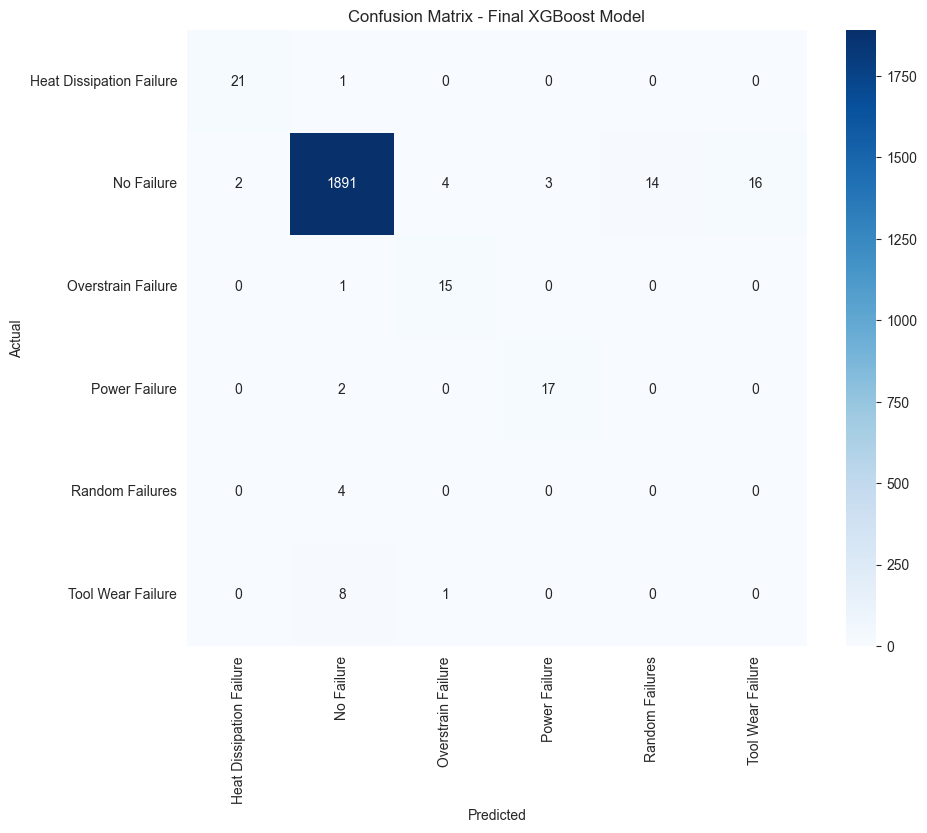

In [28]:
# رسم مصفوفة الارتباك لأفضل موديل
y_pred_final = final_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Final XGBoost Model')
plt.show()